In [1]:
# This code demonstartes in silico simulation for olfactory associative learning.
# To execute this code, please program the vivado project "FlyOlfactoryNetwork" on the FPGA. 

In [2]:
import serial
import threading
import time
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import datetime
import numpy as np
cmap = plt.get_cmap("tab10")

In [3]:
# please set port name
PORT_NAME = "COM4"
filename="../outputs/ORNcsv/ORN_4000s.csv"

# Parameters for serial communication
# If you change these parameters, you must also change the vhdl code on the FPGA
BAUD_RATE = 4000000 # baud rate
NUM_DATA = 2        # a single signal (18-bits) is sent in 2 bytes
NUM_SIGNAL = 12     # the number of received signals
NUM_BIT = 18        # signals are represented by fixed-point 18 bits
DT = 0.001          # time step of the simulation [s]
LF = 10             # line feed
SEND_TW = 0.05       # interval between data transmissions
REST_TIME = 1       # additional receive time

# global flag for controlling threads
receiver_stop_flag=0

def decoder_signals(x0,x1):
    x2=((x0-2**7)*2**7+(x1-2**7))/2**8
    if x2>32:
        x2=x2-64
    return x2

def decoder_spikes(x0,x1):
    return ((x0-2**7)*2**7+(x1-2**7))

# receiver for the serial communication
    # a packet is sent from the FPGA every DT second
    # signal0: LN0_s_sum/4
    # signal1: LN1_s_sum/4
    # signal2: LN2_s_sum/4
    # signal3: LN3_s_sum/4
    # signal4: PN_s_sum/4
    # signal5: KC_s_sum/32
    # signal6: APL_s
    # signal7: MBON0_v
    # signal8: MBON1_v
    # signal9: SMP354_v
    # signal10: APL_v
    # signal11: PN_u_sum
def receiver(ser):
    received_data=[]
    global receiver_stop_flag
    ser.reset_input_buffer()
    print("start receiving")
    while receiver_stop_flag == 0:
        if ser.in_waiting>0:
            line0 = ser.read(ser.in_waiting)
            received_data.extend(list(line0))
    print("start decoding")
    global signals
    global spikes_x
    global spikes_y
    signals=[]
    spikes=[]
    l0=[]
    si0=[]
    sp0=[]
    while received_data[0]!=LF:
        received_data.pop(0)
    received_data.pop(0)
    for i,x in enumerate(received_data):
        if received_data[i]!=LF:
            l0.append(received_data[i])
        else:
            for j in range(int(len(l0)/NUM_DATA)):
                if j < NUM_SIGNAL:
                    if j<5:
                        si0.append(decoder_signals(l0[j*NUM_DATA],l0[j*NUM_DATA+1])*4)
                    elif j<6:
                        si0.append(decoder_signals(l0[j*NUM_DATA],l0[j*NUM_DATA+1])*32)
                    else:
                        si0.append(decoder_signals(l0[j*NUM_DATA],l0[j*NUM_DATA+1]))
                else:
                    sp0.append(decoder_spikes(l0[j*NUM_DATA],l0[j*NUM_DATA+1]))
            signals.append(si0)
            spikes.append(sp0)
            l0=[]
            si0=[]
            sp0=[]
    signals = pd.DataFrame(signals).T.values.tolist()
    spikes_x=[]
    spikes_y=[]
    for i,l in enumerate(spikes):
        for x in l:
            spikes_x.append(i*DT)
            spikes_y.append(x)
    return signals,spikes_x,spikes_y

# encode a signal to 2-byte data
def encode_signal(x):
    if x>=2525+11:
        raise ValueError('too large signal')
    I0=int(int(x/2**6)+2**7)
    I1=int(x%2**6+2**6)
    return [I0, I1]

# class for transmitter of the serial communication
    # a block of packets is sent to the FPGA every SEND_TW second and stored FIFO buffer
    # packets are processed every DT second in FPGA
    # list of signals
      # 0: not used
      # 1: reward signal for LTD
      # 2: LTD reset
      # 3: PN homeostasis start
      # 4: PN homeostasis end
      # 5: LN0 onoff
      # 6: LN1 onoff
      # 7: LN2 onoff
      # 8: LN3 onoff
      # 9: PQN start
      # 10: next time step
      # 11--2536 : addrass of ORN that spikes in this time step - 11
class send_data:
    def __init__(self,tmax):
        self.command_list=[]
        self.packet_list=[]
        self.tmax=tmax
        self.ORNdata = pd.read_csv(filename, header=None).values.tolist()
    def set_command(self,t0,x0):
        self.command_list.append([t0,x0])
    def generate_packet_list(self):
        c0=0
        packet=[]
        for i in range(int((self.tmax+1)/DT)):
            while self.ORNdata[c0][0] <= i*DT:
                packet.extend(encode_signal(self.ORNdata[c0][1]+LF+1))
                c0+=1
            for j, x in enumerate(self.command_list):
                if i==int(x[0]/DT):
                    print("inserted", i*DT, "[s], command=", x[1])
                    packet.extend(encode_signal(x[1]))
            packet.extend(encode_signal(LF))
            if i%(int(SEND_TW/DT))==int(SEND_TW/DT)-1:
                self.packet_list.append(packet)
                packet=[]

    def packet_get(self):
        if len(self.packet_list)>0:
            return self.packet_list.pop(0)
    def print_vhdl_line(self,f0,x):
        f0.write("    -- "+str(x)+"\n")
        f0.write("    wait for "+str(int(10**9/BAUD_RATE))+" ns ; uart_rxd <= '0' ;\n")
        y=[]
        for i in range(8):
            if x>=2**(7-i):
                y.append(1)
                x=x-2**(7-i)
            else:
                y.append(0)
        for i in range(8):
            f0.write("    wait for "+str(int(10**9/BAUD_RATE))+" ns ; uart_rxd <= '"+str(y[7-i])+"' ;\n")
        f0.write("    wait for "+str(int(10**9/BAUD_RATE))+" ns ; uart_rxd <= '1' ;\n")
    def print_vhdl_sim(self,filename,t0):
        f0 = open(filename, 'w')
        c0=0
        for packet in self.packet_list:
            if c0*SEND_TW>t0:
                break
            for x in packet:
                self.print_vhdl_line(f0,x)
            f0.write("    -- 0.1s interval\n")
            f0.write("    wait for "+str(int(SEND_TW*10**9))+" ns ; uart_rxd <= '1' ;\n")
            c0+=1
        f0.close()

class serial_test:
    def __init__(self,tmax):
        self.tmax=tmax
        self.d0=send_data(tmax)
    def set_command(self,t0,x0):
        self.d0.set_command(t0,x0)
    def run(self):
        self.d0.generate_packet_list()
        self.d0.print_vhdl_sim("vhdl_sim.txt",0.001)
        ser = serial.Serial(PORT_NAME, baudrate=BAUD_RATE, bytesize=serial.EIGHTBITS, parity=serial.PARITY_NONE)
        ser.set_buffer_size(rx_size=12800, tx_size=12800)
        thread1 = threading.Thread(target=receiver, args=(ser,))
        thread1.start()
        t1=time.time()
        t2=time.time()
        k0=0
        for i in range(7):
            ser.write(self.d0.packet_get())
        while t2-t1<self.tmax:
            ser.write(self.d0.packet_get())
            k0+=1
            t2=time.time()
            if SEND_TW*k0-(t2-t1)>0:
                time.sleep(SEND_TW*k0-(t2-t1))
        global receiver_stop_flag
        time.sleep(REST_TIME)
        receiver_stop_flag=1
        thread1.join()
        ser.close()
        return signals,spikes_x,spikes_y

In [4]:
P=6
duration=5
LN_max=191
PN_max=312
KC_max=2231

In [5]:
iteration=3
epoch=2
homeostasis_duration=300

#length of simulation [s]
tmax=homeostasis_duration+P*P*duration*(iteration+1)*epoch+10
print(tmax)

# set serial communication
se0=serial_test(tmax)
se0.set_command(0,9)
se0.set_command(0,3)
se0.set_command(homeostasis_duration,4)

for i in range(P):
    for j in range(epoch):
        se0.set_command(homeostasis_duration+P*duration*(iteration+1)*epoch*i+P*duration*(iteration+1)*j+i*duration+4,1)
        se0.set_command(homeostasis_duration+P*duration*(iteration+1)*epoch*i+P*duration*(iteration+1)*(j+1),2)
        
# run serial communication
signals,spikes_x,spikes_y=se0.run()
#print(signals)

1750
inserted 0.0 [s], command= 9
inserted 0.0 [s], command= 3
inserted 300.0 [s], command= 4
inserted 304.0 [s], command= 1
inserted 420.0 [s], command= 2
inserted 424.0 [s], command= 1
inserted 540.0 [s], command= 2
inserted 549.0 [s], command= 1
inserted 660.0 [s], command= 2
inserted 669.0 [s], command= 1
inserted 780.0 [s], command= 2
inserted 794.0 [s], command= 1
inserted 900.0 [s], command= 2
inserted 914.0 [s], command= 1
inserted 1020.0 [s], command= 2
inserted 1039.0 [s], command= 1
inserted 1140.0 [s], command= 2
inserted 1159.0 [s], command= 1
inserted 1260.0 [s], command= 2
inserted 1284.0 [s], command= 1
inserted 1380.0 [s], command= 2
inserted 1404.0 [s], command= 1
inserted 1500.0 [s], command= 2
inserted 1529.0 [s], command= 1
inserted 1620.0 [s], command= 2
inserted 1649.0 [s], command= 1
inserted 1740.0 [s], command= 2
start receiving
start decoding


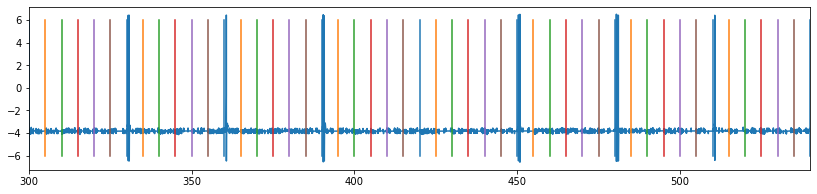

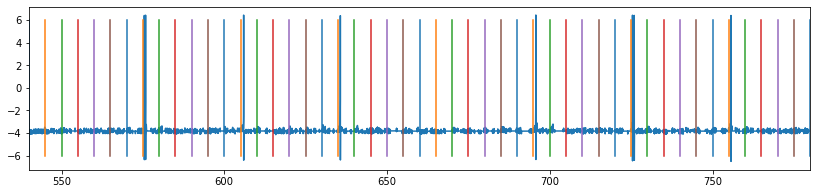

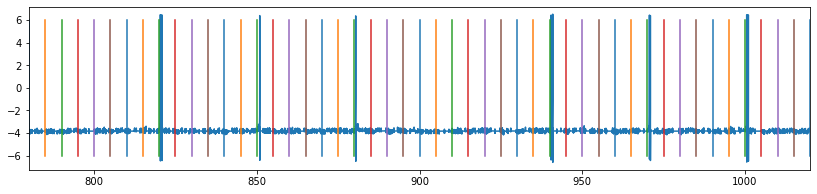

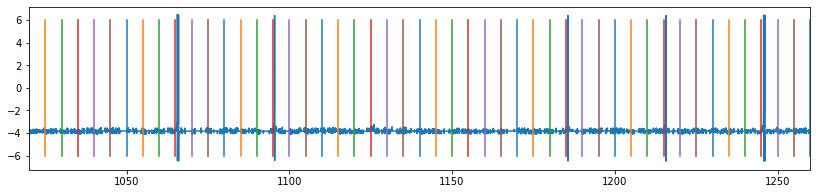

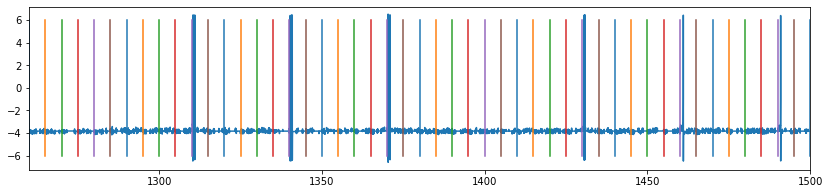

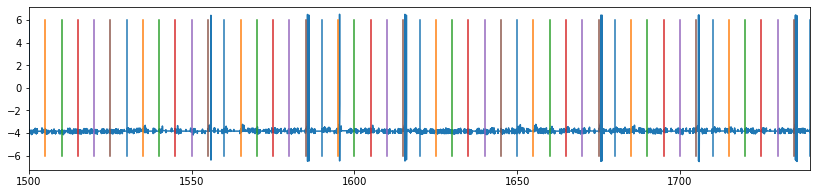

In [6]:
for i in range(P):
    plt.figure(figsize=(14,3))
    plt.plot([i * 0.001 for i in range(len(signals[9]))],signals[9])
    for j in range(int(tmax/duration)):
        plt.plot([duration*j,duration*j],[-6,6],color=cmap(j%P))
    plt.xlim((homeostasis_duration+P*duration*(iteration+1)*epoch*i),(homeostasis_duration+P*duration*(iteration+1)*epoch*(i+1)))
    plt.show()